In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
import random

### Calibration

In [2]:
"""
For each file, look for corners. If found, save image and corners.
Object points explanation here: https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/a30f45cb-c1c0-482c-8e78-a26604841ec0
"""
def calibrate(directory=''):
    objp = np.zeros((9*6,3),np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    pathname = directory + '/*.jpg'
    fnames = glob.glob(pathname)
    objpoints = []
    imgpoints = []
    images = []
    for fname in fnames:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        if ret == True:
            imgpoints.append(corners)
            images.append(img)
            objpoints.append(objp)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, gray.shape[::-1],None,None)
    return mtx, dist, images, imgpoints

In [3]:
"""
Calibrate the camera
"""
mtx, dist, images, imgpoints = calibrate('camera_cal')

### Visualize images

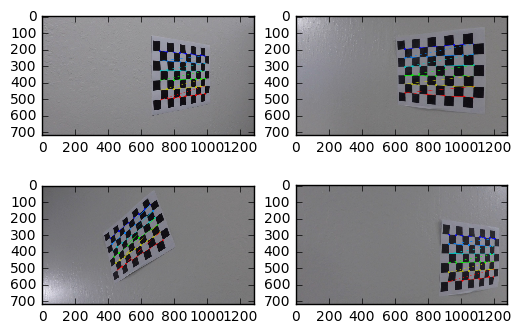

In [4]:
"""
Four random images before undistortion, with corners drawn
"""
for a in range(1,5):
    i = random.randint(0, len(images)-1)
    
    img_drawn = np.copy(images[i])
#     img_drawn = np.empty_like(images[i])
#     img_drawn[:] = images[i]
    
    corners = imgpoints[i]
    
    plt.subplot(2,2,a)
    img_drawn = cv2.drawChessboardCorners(img_drawn, (9,6), corners, True)
    
    plt.imshow(img_drawn)

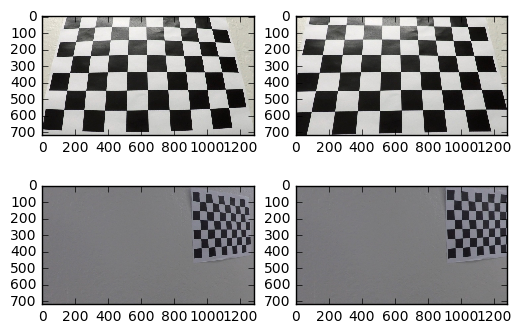

In [5]:
"""
Draw before and after undistortion for 2 images at random
"""
for a in range(1,4,2):
    i = random.randint(0, len(images)-1)
    img = images[i]
    
    plt.subplot(2,2,a)
    plt.imshow(img)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    plt.subplot(2,2,a+1)
    plt.imshow(dst)

### Image processing functions

#### Gradient thresholding

In [388]:
def abs_sobel_thresh(img, orient='x',sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

In [389]:
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return mag_binary

In [390]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

#### Color thresholding

In [406]:
def sat_threshold(img, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    sat = gray[:,:,2]
    sat_binary = np.zeros_like(S)
    sat_binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return sat_binary

#### Combining methods into binary image

In [435]:
def binary_image(img):
    """
    Returns binary image after applying:
    + gradient thresholding
    + color thresholding
    - masking?
    - hough transform?
    """
    ksize=3
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 200))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 200))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, thresh=(20, 200))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(1/3*np.pi/2, 2/3*np.pi/2))
    sat_binary = sat_threshold(img, thresh=(150, 255))
    combined = np.zeros_like(gradx)
    combined[((gradx == 1) | (grady == 1) | (mag_binary == 1)) 
             & (dir_binary == 1) 
             | (sat_binary == 1)] = 1
    return combined

#### Perspective transform

In [598]:
def transform_perspective(img):
    rows = img.shape[0]
    cols = img.shape[1]
    img_size = (cols, rows)
    slope_right = 0.6738857501569366
    slope_left = slope_right * -1
    delta_x = 0.3

    bl = (cols*0.15,rows)
    tl = (cols*(0.15+delta_x),rows + cols*(delta_x)*slope_left)
    br = (cols*0.88,rows)
    tr = (cols*(0.88-delta_x),rows + cols*(-delta_x)*slope_right)

    src = np.float32([[bl[0],bl[1]],[tl[0],tl[1]],[tr[0],tr[1]],[br[0],br[1]]])
    dst = np.float32([[bl[0],bl[1]],[bl[0],0],[br[0],0],[br[0],br[1]]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped

#### Select points that are part of lines

### Image pipeline

In [599]:
def image_pipeline(img,mtx,dist,left=None,right=None):
    """
    Returns lane boundaries, curvature, vehicle position, and left/right line objects
    
    Steps:
    + undistortion
    + detecting points, creating binary image:
    + transforming perspecive
    - selecting points that are part of lines
    - as above, but get hints based on recent frames
    - fitting curves, defining lane boundaries
    - determining curvature
    - sanity checks (l/r  similar curvature, their separation is reasonable, l/r parallel)
    - if doesn't pass check, use previous image. enough times in a row, then ignore recent frames
    - smooth over past n
    - updating line objects
    """
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    dst = binary_image(dst)
    dst = transform_perspective(dst)
    lane_boundaries = None
    curvature = None
    position = None
    return dst, lane_boundaries, curvature, position, left, right

### Test: single image

267 1057.0


//anaconda/envs/behavioral-cloning/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/behavioral-cloning/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/behavioral-cloning/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/behavioral-cloning/lib/python3.5/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


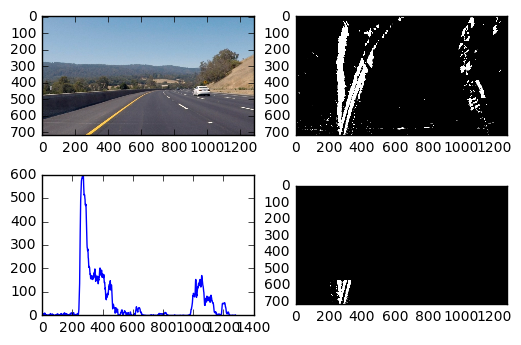

In [642]:
img = mpimg.imread('test_images/test3.jpg')
dst, lane_boundaries, curvature, position, left, right = \
    image_pipeline(img,mtx,dist,left=None,right=None)
plt.subplot(2,2,1)
plt.imshow(img)
plt.subplot(2,2,2)
plt.imshow(dst,cmap='gray')

rows = dst.shape[0]
cols = dst.shape[1]

window_h = 0.2*rows
window_w = 0.05*cols

plt.subplot(2,2,3)
histogram = np.sum(dst[dst.shape[0]*(1-window_h):,:], axis=0)
plt.plot(histogram)
mid = len(histogram)/2
left = np.argmax(histogram[:mid])
right = np.argmax(histogram[mid:]) + mid
print(left,right)

line_mask = np.zeros_like(dst)
line_mask[rows-window_h:rows,left - window_w:left + window_w] = 1
keepers = np.zeros_like(dst)
keepers[(line_mask == 1) & (dst == 1)] = 1
plt.subplot(2,2,4)
plt.imshow(keepers,cmap='gray')

### Scratch

#### Figure out src and dst points for perspective transform

0.6738857501569366


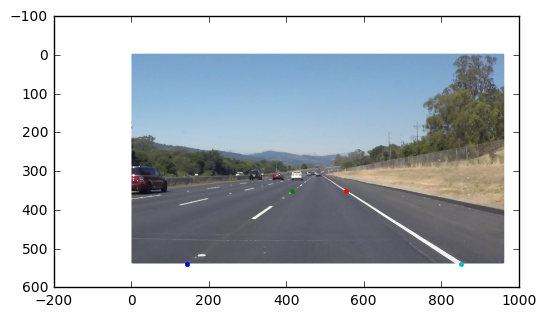

In [589]:
img = mpimg.imread('test_images/solidWhiteRight.jpg')
plt.imshow(img)
plt.plot(145,540,'.')
plt.plot(415,350,'.')
plt.plot(555,350,'.')
plt.plot(850,540,'.')
# to help define perspective transform, eyeball some points and get the approximate slopes
abs_slope_left = abs((350-540)/(415-145))
abs_slope_right = abs((350-540)/(555-850))
avg_slope = (abs_slope_left + abs_slope_right)/2
print(avg_slope)

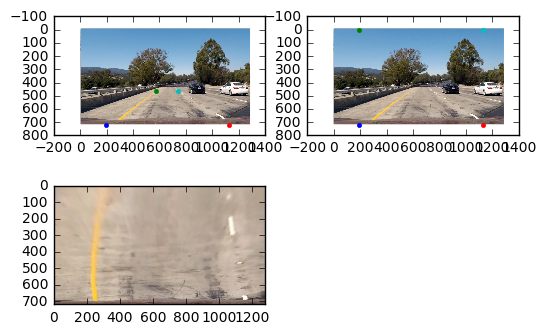

In [602]:
img = mpimg.imread('test_images/test1.jpg')
rows = img.shape[0]
cols = img.shape[1]
img_size = (cols, rows)

slope_right = 0.6738857501569366
slope_left = slope_right * -1

delta_x = 0.3 #.34

bl = (cols*0.15,rows)
tl = (cols*(0.15+delta_x),rows + cols*(delta_x)*slope_left)

br = (cols*0.88,rows)
tr = (cols*(0.88-delta_x),rows + cols*(-delta_x)*slope_right)

plt.subplot(2,2,1)
plt.imshow(img)
plt.plot(bl[0],bl[1],'.')
plt.plot(tl[0],tl[1],'.')
plt.plot(br[0],br[1],'.')
plt.plot(tr[0],tr[1],'.')

src = np.float32([[bl[0],bl[1]],[tl[0],tl[1]],[tr[0],tr[1]],[br[0],br[1]]])
dst = np.float32([[bl[0],bl[1]],[bl[0],0],[br[0],0],[br[0],br[1]]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

plt.subplot(2,2,2)
plt.imshow(img)
plt.plot(bl[0],bl[1],'.')
plt.plot(bl[0],0,'.')
plt.plot(br[0],br[1],'.')
plt.plot(br[0],0,'.')

plt.subplot(2,2,3)
plt.imshow(warped)

(540, 960, 3)
-0.7037037037037037
0.6440677966101694


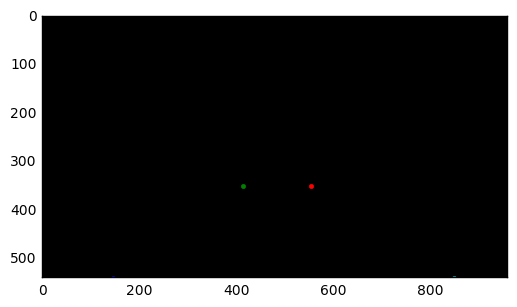

In [564]:
img = mpimg.imread('test_images/solidWhiteRight.jpg')
print(img.shape)
img_size = (img.shape[1], img.shape[0]) # number of columns comes first for warpPerspective
plt.imshow(img)
src = np.float32([[275,720],[500,550],[860,550],[1150,720]])
dst = np.float32([[275,720],[275,0],[1150,0],[1150,720]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(img)
plt.plot(145,540,'.')
plt.plot(415,350,'.')
plt.plot(555,350,'.')
plt.plot(850,540,'.')

print((350-540)/(415-145))
print((350-540)/(555-850))
plt.imshow(warped)

Pre-processing:
- Calibration

Image pipeline:
- Distortion correction
- Create binary image (gradients, colors, masks, etc)
- Perspective transform
- Pick out the lane lines
- Determine curvature
- Transform boundaries back to original image

In [ ]:
def process_video():
    get_frame()
    
    if(fail_count > max_fail):
        locked = False
        fail_count = 0
        
    if(locked):
        smart_search()
        if(sanity_check()):
            update_line()
        else:
            use last frame
            update fail count
    else:
        blind_search()